# Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
class GeneticAlgorithm():
    def __init__(self):
        
        self.x_train = list()
        self.y_train = list()
        
        self.model = tf.keras.Sequential() # NN model for objective funciton
        self.shape = list() # stracture of NN

        self.n_generations = int() # number of generations
        self.pop_size = int() # number of chromosome in each population
        self.mutation_prob = float()
        self.protected = int() # number of chromosomes that will be transfered to next generation without any change

        self.log = list() # best value of each generation
        
        self.generations = list()
        self.generation_range = list() # range of numbers in each generation

        self.noise = lambda: np.random.normal(0, 50) # noise that will be added for mutation
        self.best = list() # best chromosome after training
        self.loss_hist = list()
        self.auc_hist = list()

    def create_chromosome(self, input_dim, shape, r):
        """
        Creates a chromosome in given NN stracture and range
        """
        
        chromosome = list()

        w = self.random_matrix((input_dim, shape[0]), r)
        b = self.random_matrix((shape[0],), r)
        chromosome.append([w,b])
        for i in range(1,len(shape)):
            w = self.random_matrix((shape[i-1], shape[i]), r)
            b = self.random_matrix((shape[i],), r)
            chromosome.append([w,b])
        return chromosome

    def random_matrix(self, shape, r):
        """
        Returns a random matrix in given shape and range
        """
        return np.random.random(shape) * (r[1] - r[0]) * 1.2 + r[0] * 1.1 - r[1] * 0.1

    def random_number(self, r):
        """
        Returns random number in -+ 10% interval of given range
        """
        return np.random.random() * (r[1] - r[0]) * 1.2 + r[0] * 1.1 - r[1] * 0.1

    def objective(self, c = None):
        """
        Objective function determines how good is given chromosome
        """
        if c is None: c = self.best

        # set weights of NN as given chromosome
        self.set_model_weights(c)
        # evalutes the model with chromosome
        loss, auc = self.model.evaluate(self.x_train, self.y_train, verbose = 0) 
    
        return loss, auc    

    def set_model_weights(self, chromosome):
        """
        Changes model weights
        """
        for layer, c in zip(self.model.layers, chromosome):
            layer.set_weights(c)

    def generate_population(self):
        """
        Generates random population
        """
        first_pop = list()
        r = (-100, 100) # initial range
        for _ in range(self.pop_size):
            
            c = self.create_chromosome(self.x_train.shape[-1], self.shape, r)
            first_pop.append(c)

        # first generation range is [-100, 100]
        self.generation_range.append([-100, 100])
        return first_pop
    
    def selection(self, population):
        """
        Selectes best 1/4 of the population for creating next generation
        """
        sorted_population = sorted(population, key = lambda c: self.objective(c)[0])
        loss, auc = self.objective(sorted_population[0]) # appends best value of the generation to history
        self.loss_hist.append(loss)
        self.auc_hist.append(auc)
        return sorted_population[:int(self.pop_size/4) + 1]
    
    def crossingover(self, selected):
        """
        Creates new random generation using selected chromosomes of the previous generaiton
        """

        new_range = [float("inf"), float("-inf")] # new populations range
        new_pop = list()

        for i in range(self.protected): # protected chromosomes will transferred to next generation without any change
            new_pop.append(selected[i])

        while len(new_pop) < self.pop_size:
            perent1, perent2 = np.random.choice(range(len(selected)), size = 2, replace = False)
            perent1, perent2 = selected[perent1], selected[perent2] # choose perents of new chromosome

            # iterate over 2 chromosomes and create a random chromosome between them
            new_chromosome = list()
            for layer1, layer2 in zip(perent1, perent2):
                new_layer = list()

                new_weights = list()
                for i1, i2 in zip(layer1[0], layer2[0]):
                    new_row = list()
                    for j1, j2 in zip(i1, i2):

                        new_w = self.random_number([j1,j2])
                        if new_w < new_range[0]: new_range[0] = new_w
                        elif new_w > new_range[1]: new_range[1] = new_w

                        new_row.append(new_w)
                    new_weights.append(new_row)
                
                new_biases = list()
                for bias1, bias2 in zip(layer1[1], layer2[1]):
                    new_b = self.random_number([bias1, bias2])
                    if new_b < new_range[0]: new_range[0] = new_b
                    elif new_b > new_range[1]: new_range[1] = new_b
                    new_biases.append(new_b)
                new_chromosome.append([np.array(new_weights), np.array(new_biases)])
            
            # append new chromosome to new population
            new_pop.append(new_chromosome)
        
        self.generation_range.append(new_range)
        return new_pop
    
    def mutation(self, new_pop):
        """
        mutates the chromosomes by some probability
        """

        # iterates over the chromosome and checks for mutation condition
        for chromosome in new_pop[self.protected:]: # protecte chromosomes will not be changed
            for layer in chromosome:

                # mutation for weights 
                for i in layer[0]:
                    for j in range(len(i)):
                        if np.random.random() < self.mutation_prob:
                            i[j] += self.noise()
                
                # mutation for biases
                for i in range(len(layer[1])):
                    if np.random.random() < self.mutation_prob:
                        layer[1][i] += self.noise()

        return new_pop

    def train(self, x_train, y_train, shape, pop_size, n_generations, mutation_prob, protected = None, verbose = 0):
        
        self.x_train = x_train
        self.y_train = y_train

        self.shape = shape

        # creates a model for objective function in given NN stracture
        self.model.add(tf.keras.layers.Dense(units = shape[0], activation = "relu", input_dim = self.x_train.shape[-1]))
        for i in shape[1:-1]:
            self.model.add(tf.keras.layers.Dense(units = i, activation = "relu"))
        self.model.add(tf.keras.layers.Dense(units = shape[-1], activation = "sigmoid"))
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics = tf.keras.metrics.AUC()) # compiles the model

        self.pop_size = pop_size
        self.n_generations = n_generations
        self.mutation_prob = mutation_prob  
        self.protected = int(pop_size / 16) + 1 if not protected else protected

        first_pop = self.generate_population() # generates first population
        self.generations.append(first_pop)
        for _ in range(n_generations):
            selected = self.selection(self.generations[-1]) # Selectes perents for next generation using objective function
            new_pop = self.crossingover(selected) # creates new population using perents
            new_pop = self.mutation(new_pop) # mutate chromosomes
            self.generations.append(new_pop) # append new generation to generation history

            if verbose and _%5==0: print(f"Iteration {_},\t Loss_value: {self.loss_hist[-1]}")

        self.best = self.selection(self.generations[-1])[0] # return best chromosome
    
        return self.best, self.loss_hist, self.auc_hist

def simulated_annealing(X_train, y_train, X_test, y_test, max_iter=100, T=1, cooling_rate=0.95):
    
    T_begin = T  # Keep the initial value of T (temperature) in a variable
    
    # Initialize the current solution randomly
    current_solution = np.random.choice([True, False], p=[1, 0], size=X_train.shape[1])
    current_objective = objective_function(current_solution, X_train, y_train, X_test, y_test)
    
    # Initialize the best solution and its objective value
    best_solution = current_solution.copy()
    best_objective = current_objective
    best_objectives = [current_objective]

    for i in range(max_iter):
        
        neighbor_solution = current_solution.copy()
        
        num_feats = neighbor_solution.sum()
        #print(f"Chosen feats: {num_feats}")
        
        # Randomly select a neighbor solution by flipping the value of a random feature
        random_index = np.random.randint(0, X_train.shape[1] - 1)
        
        # An if block to control unexpected decrease in number of features
        if num_feats > 2*X_train.shape[1]//3 and neighbor_solution[random_index]:
            random_index = np.random.randint(0, X_train.shape[1] - 1)
            
        neighbor_solution[random_index] = not neighbor_solution[random_index]

        # Call the objective with the neighbor solution (new feature set)
        neighbor_objective = objective_function(neighbor_solution, X_train, y_train, X_test, y_test, 3)

        # Calculate the change in objective value
        delta_objective = neighbor_objective - current_objective

        
        prob = 1 / (1 + np.exp(-300*delta_objective / (T/T_begin))) # The probability value
        # Even if the neighbor solution is not satisfying, update current solution with some probability
        if delta_objective > 0 or np.random.uniform(0, 1) < prob:
            current_solution = neighbor_solution.copy()
            current_objective = neighbor_objective

        # Update the best solution if necessary
        if current_objective > best_objective:
            best_solution = current_solution.copy()
            best_objective = current_objective
            best_objectives.append(current_objective)

        # Update the temperature
        
        T *= cooling_rate
        if i%10==0:
            print(f"iter: {i} | T: {T}")
    return best_solution, best_objectives


def objective_function(solution, X_train, y_train, X_test, y_test, iters=1):
    
    # create a list consists of the feature names that we will use
    selected_features = [feature for feature, select in zip(X_train.columns, solution) if select]
    X_selected = X_train[selected_features].values
    y_train = y_train.values

    X_selected_test = X_test[selected_features].values  # test set

    model = nnModel(X_selected) # calls the NN model
    
    # list to keep the auc values
    aucs = []

    for i in range(iters):

        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=tf.keras.metrics.AUC())
        model.fit(X_selected, y_train, epochs=10, batch_size=32, verbose=0)

        preds = model.predict(X_selected_test, verbose=0)
        score = roc_auc_score(y_test, preds)

        aucs.append(score)
        
    # get the average score   
    score = sum(aucs)/iters
    
    return score


def nnModel(X_train):

    # basic Neural Network Model
    model1 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=8, activation="relu", input_dim=X_train.shape[1]),
        tf.keras.layers.Dense(units=16, activation="relu"),
        tf.keras.layers.Dense(units=1, activation="sigmoid")
    ])

    return model1




def preprocess(df):
    
    # Scale the data and split into train and test sets
    to_scale = df.columns.tolist()[:-1]

    mms = MinMaxScaler() 
    df[to_scale] = mms.fit_transform(df[to_scale])

    X = df.drop(columns=["target"])
    y = df["target"]

    return train_test_split(X, y, test_size=0.2, random_state=2)


def plot_history(all_feats, random, selected):
    
    # Function to plot loss and AUC values for 3 different cases
    l1, auc1 = selected.history["loss"], list(selected.history.values())[1]
    l2, auc2 = random.history["loss"], list(random.history.values())[1]
    l3, auc3 = all_feats.history["loss"], list(all_feats.history.values())[1]
    
    epochs = range(len(l1))
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the loss on the first subplot
    axs[0].plot(epochs, l1, c="r", label="Selected loss")
    axs[0].plot(epochs, l2, c="b", label="Random Loss")
    axs[0].plot(epochs, l3, c="g", label="All feats loss")
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Loss')
    
    # Plot the AUC on the second subplot
    axs[1].plot(epochs, auc1, c="r", label="Selected auc")
    axs[1].plot(epochs, auc2, c="b", label="Random auc")
    axs[1].plot(epochs, auc3, c="g", label="All auc")
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('AUC')
    axs[1].set_title('AUC')
    
    # Adjust the layout to prevent overlapping of subplots
    plt.tight_layout()
    axs[0].legend()
    axs[1].legend()
    
    # Show the plots
    plt.show()
    
    

def plot_hist(loss, auc, title):
    
    epochs = range(len(loss))
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the loss on the first subplot
    axs[0].plot(epochs, loss, c="r", label="Loss")
    axs[0].set_title('Loss Value', fontsize = 16)
    
    # Plot the AUC on the second subplot
    axs[1].plot(epochs, auc, c="r", label="AUC Score")
    axs[1].set_title('AUC Score', fontsize = 16)
    
    # Adjust the layout to prevent overlapping of subplots
    fig.text(0.51, -.03, "epoch", ha='center', fontsize = 14)
    fig.suptitle(title, fontsize = 20)
    plt.tight_layout()
    axs[0].legend()
    axs[1].legend()
    
    # Show the plots
    plt.show()

# Import Data and Preprocess

In [4]:
# Load data
breast_cancer = load_breast_cancer()

# Convert data into pd dataframe
df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names, )
df['target'] = breast_cancer.target

# Preprocess data
X_train, X_test, y_train, y_test = preprocess(df)

# Use Only Gradient Model to Predict (Tensorflow NN)

In [5]:
# Create tensorflow sequential neural network 
model = nnModel(X_train)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = tf.keras.metrics.AUC())

# Train model
model1_hist = model.fit(X_train, y_train, epochs=10, verbose=1)

# Evaluate the model
loss, AUC = model.evaluate(X_test, y_test)
print("Loss:", loss, "AUC Score: ", AUC)

Epoch 1/10
15/15 [==============================] - 0s 993us/step - loss: 0.6808 - auc: 0.6457
Epoch 2/10
15/15 [==============================] - 0s 991us/step - loss: 0.6648 - auc: 0.8091
Epoch 3/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6484 - auc: 0.9075
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6305 - auc: 0.9393
Epoch 5/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6086 - auc: 0.9676
Epoch 6/10
15/15 [==============================] - 0s 1ms/step - loss: 0.5838 - auc: 0.9689
Epoch 7/10
15/15 [==============================] - 0s 1ms/step - loss: 0.5543 - auc: 0.9761
Epoch 8/10
15/15 [==============================] - 0s 1ms/step - loss: 0.5216 - auc: 0.9811
Epoch 9/10
15/15 [==============================] - 0s 2ms/step - loss: 0.4858 - auc: 0.9824
Epoch 10/10
4/4 [==============================] - 0s 1ms/step - loss: 0.4304 - auc: 0.9670
Loss: 0.430448055267334 AUC Score:  0.9669886827468872


# Use Genetic Algorithm to Train Model

In [6]:
shape = [8,16,1] # Shape must be same with the stracture of NN
pop_size = 100 # Number or chromosomes in one population
n_generations = 50 # Number of generaions
mutation_prob = 0.1 # Mutation probability
# protected = 2 # Number of protected chromosomes

# Create genetic algorithm model
gen = GeneticAlgorithm()

# Train genetic algorithm model
best, loss_hist, auc_hist = gen.train(X_train, y_train, shape, pop_size, n_generations, mutation_prob, verbose = 1)

Iteration 0,	 Loss_value: 97519.8828125
Iteration 5,	 Loss_value: 393.4578552246094
Iteration 10,	 Loss_value: 16.824337005615234
Iteration 15,	 Loss_value: 2.5859291553497314
Iteration 20,	 Loss_value: 2.5859291553497314
Iteration 25,	 Loss_value: 2.5859291553497314
Iteration 30,	 Loss_value: 1.4568171501159668
Iteration 35,	 Loss_value: 0.6796901226043701
Iteration 40,	 Loss_value: 0.6796901226043701
Iteration 45,	 Loss_value: 0.6796901226043701


# Test Model

In [7]:
# Test the performance of genetic algorithm
for layer, c in zip(model.layers, best):
    layer.set_weights(c) # Set tensorflow model's weigth to weight from genetic algorithm

loss, AUC = model.evaluate(X_test, y_test)
print("Loss: ", loss, "AUC Score: ", AUC)

4/4 [==============================] - 0s 2ms/step - loss: 0.6828 - auc: 0.5000
Loss:  0.6828277707099915 AUC Score:  0.5


# Use Genetic Algorithm to Initialize Weights

In [8]:
# Train nn model with initial weights
model2_hist = model.fit(X_train, y_train, epochs=20, verbose = 1)

# Evaluate performance
loss, AUC = model.evaluate(X_test, y_test, verbose = 0)
print("Loss: ", loss, "AUC Score: ", AUC)

Epoch 1/20
15/15 [==============================] - 0s 955us/step - loss: 0.6947 - auc: 0.5235
Epoch 2/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6755 - auc: 0.5439
Epoch 3/20
15/15 [==============================] - 0s 1ms/step - loss: 0.7033 - auc: 0.4596
Epoch 4/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6675 - auc: 0.4391
Epoch 5/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6648 - auc: 0.4309
Epoch 6/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6703 - auc: 0.4784
Epoch 7/20
15/15 [==============================] - 0s 994us/step - loss: 0.6599 - auc: 0.4763
Epoch 8/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6654 - auc: 0.4866
Epoch 9/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6618 - auc: 0.5247
Epoch 10/20
15/15 [==============================] - 0s 932us/step - loss: 0.6680 - auc: 0.4957
Epoch 11/20
15/15 [==============================] - 0s 1ms/ste

# Plots

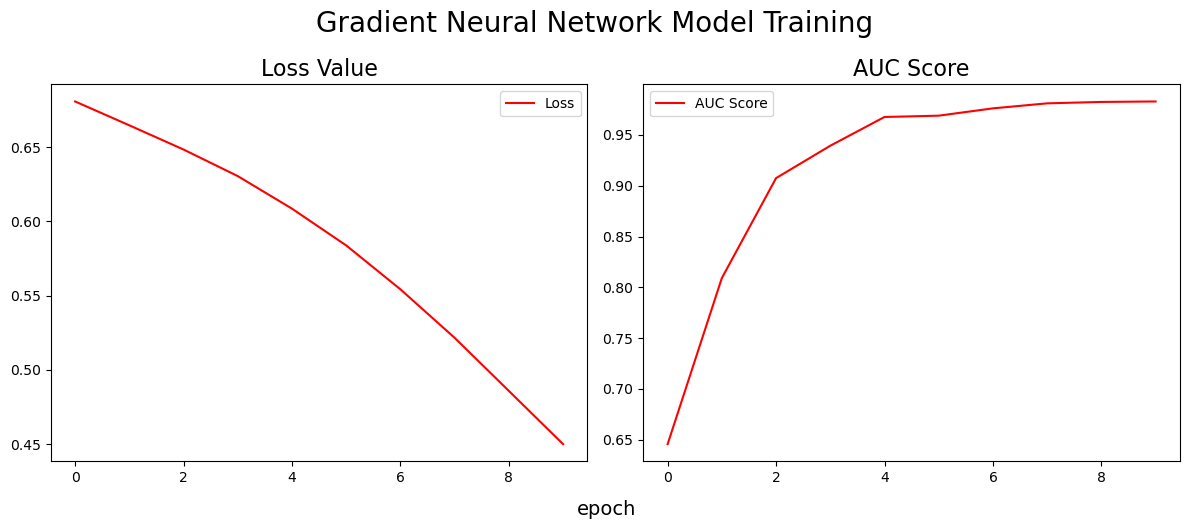

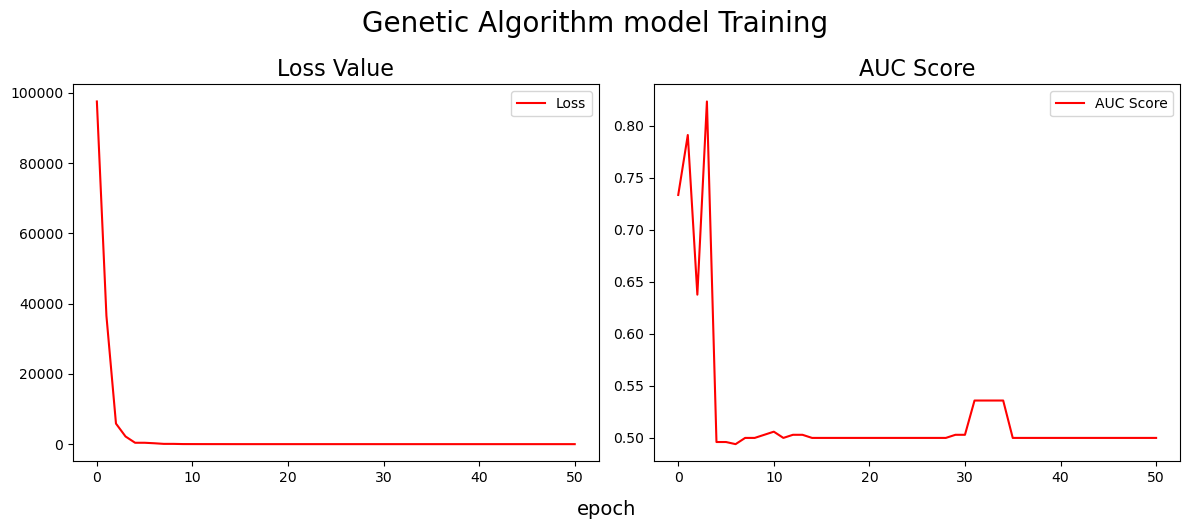

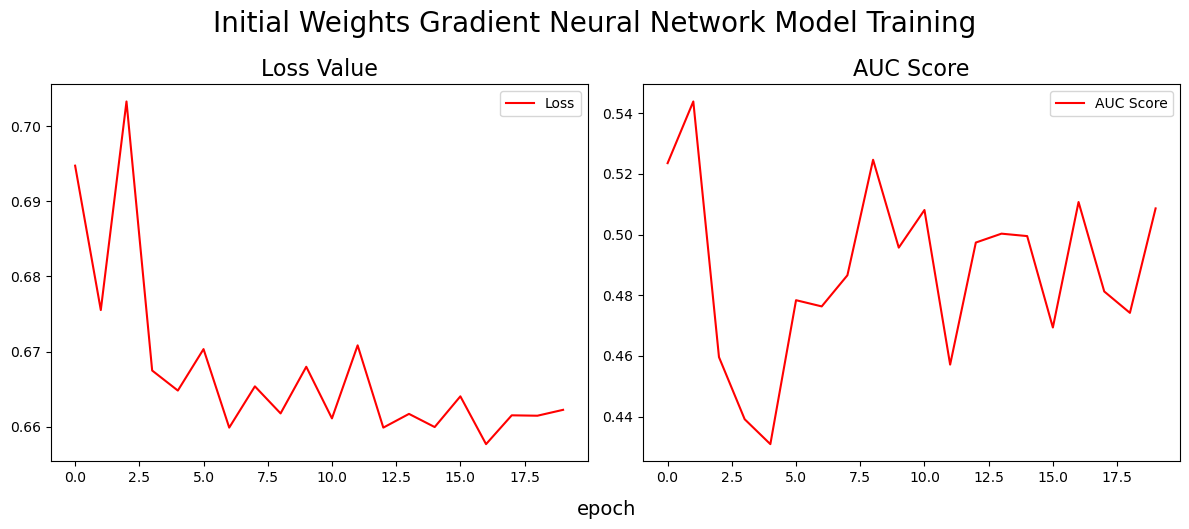

In [9]:
plot_hist(model1_hist.history["loss"], list(model1_hist.history.values())[1], "Gradient Neural Network Model Training")
plot_hist(loss_hist, auc_hist, "Genetic Algorithm model Training")
plot_hist(model2_hist.history["loss"], list(model2_hist.history.values())[1], "Initial Weights Gradient Neural Network Model Training")

# Use Simulated Annealing for Feature Selection

In [10]:
selected_feaures, _ = simulated_annealing(X_train, y_train, X_test, y_test, max_iter=20, T=1, cooling_rate=0.95)

# The features selected by simulated annealing method
s_features = [feature for feature, select in zip(X_train.columns, selected_feaures) if select]

selected_num = len(s_features) # Number of selected features

iter: 0 | T: 0.95
iter: 10 | T: 0.5688000922764596


# All Features

In [11]:
# Create a nnModel and train it to see the performance of all features case

model1 = nnModel(X_train)
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=tf.keras.metrics.AUC())


history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


preds = model1.predict(X_test)
score = roc_auc_score(y_test, preds)

print(f"score all feats: {score}\nfeats:{X_train.shape[1]}")

Epoch 1/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6868 - auc_63: 0.5550
Epoch 2/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6743 - auc_63: 0.7675
Epoch 3/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6586 - auc_63: 0.8194
Epoch 4/10
15/15 [==============================] - 0s 882us/step - loss: 0.6381 - auc_63: 0.8697
Epoch 5/10
15/15 [==============================] - 0s 920us/step - loss: 0.6115 - auc_63: 0.8828
Epoch 6/10
15/15 [==============================] - 0s 998us/step - loss: 0.5762 - auc_63: 0.9176
Epoch 7/10
15/15 [==============================] - 0s 990us/step - loss: 0.5342 - auc_63: 0.9335
Epoch 8/10
15/15 [==============================] - 0s 1ms/step - loss: 0.4874 - auc_63: 0.9521
Epoch 9/10
15/15 [==============================] - 0s 1ms/step - loss: 0.4435 - auc_63: 0.9614
Epoch 10/10
4/4 [==============================] - 0s 1ms/step
score all feats: 0.9677938808373591
feats:30


# Random Selection Results

In [12]:
# Create a nnModel and train it to see the performance of random features case

rand_i = np.random.randint(0, 30, selected_num)

rand_f = X_train.columns[rand_i]
rand_data = X_train[rand_f]

model2 = nnModel(rand_data)
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=tf.keras.metrics.AUC())

history2 = model2.fit(rand_data, y_train, epochs=10, batch_size=32, verbose=1)

X_test_random = X_test[rand_f]
preds = model2.predict(X_test_random)
score_random = roc_auc_score(y_test, preds)

print(f"score random: {score_random}\n{len(rand_f)}")

Epoch 1/10
15/15 [==============================] - 0s 831us/step - loss: 0.6698 - auc_64: 0.9672
Epoch 2/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6404 - auc_64: 0.9638
Epoch 3/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6160 - auc_64: 0.9694
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 0.5929 - auc_64: 0.9583
Epoch 5/10
15/15 [==============================] - 0s 948us/step - loss: 0.5647 - auc_64: 0.9661
Epoch 6/10
15/15 [==============================] - 0s 900us/step - loss: 0.5361 - auc_64: 0.9646
Epoch 7/10
15/15 [==============================] - 0s 1ms/step - loss: 0.5043 - auc_64: 0.9563
Epoch 8/10
15/15 [==============================] - 0s 1ms/step - loss: 0.4705 - auc_64: 0.9612
Epoch 9/10
15/15 [==============================] - 0s 1ms/step - loss: 0.4382 - auc_64: 0.9613
Epoch 10/10
4/4 [==============================] - 0s 838us/step
score random: 0.9578099838969404
27


# Simulated Annealing Results

In [13]:
# Create a nnModel and train it to see the performance of selected features case

X_train_selected = X_train[s_features]

model3 = nnModel(X_train_selected)
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=tf.keras.metrics.AUC())

history3 = model3.fit(X_train_selected, y_train, epochs=10, batch_size=32, verbose=1)

X_test_selected = X_test[s_features]
preds = model3.predict(X_test_selected)
score_selected = roc_auc_score(y_test, preds)
print(f"score selected: {score_selected}\n{len(s_features)}")

Epoch 1/10
15/15 [==============================] - 0s 957us/step - loss: 0.6950 - auc_65: 0.9461
Epoch 2/10
15/15 [==============================] - 0s 922us/step - loss: 0.6755 - auc_65: 0.9650
Epoch 3/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6622 - auc_65: 0.9662
Epoch 4/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6508 - auc_65: 0.9668
Epoch 5/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6392 - auc_65: 0.9720
Epoch 6/10
15/15 [==============================] - 0s 984us/step - loss: 0.6262 - auc_65: 0.9747
Epoch 7/10
15/15 [==============================] - 0s 1ms/step - loss: 0.6112 - auc_65: 0.9755
Epoch 8/10
15/15 [==============================] - 0s 985us/step - loss: 0.5920 - auc_65: 0.9775
Epoch 9/10
15/15 [==============================] - 0s 932us/step - loss: 0.5670 - auc_65: 0.9782
Epoch 10/10
4/4 [==============================] - 0s 841us/step
score selected: 0.962962962962963
27


# Plots

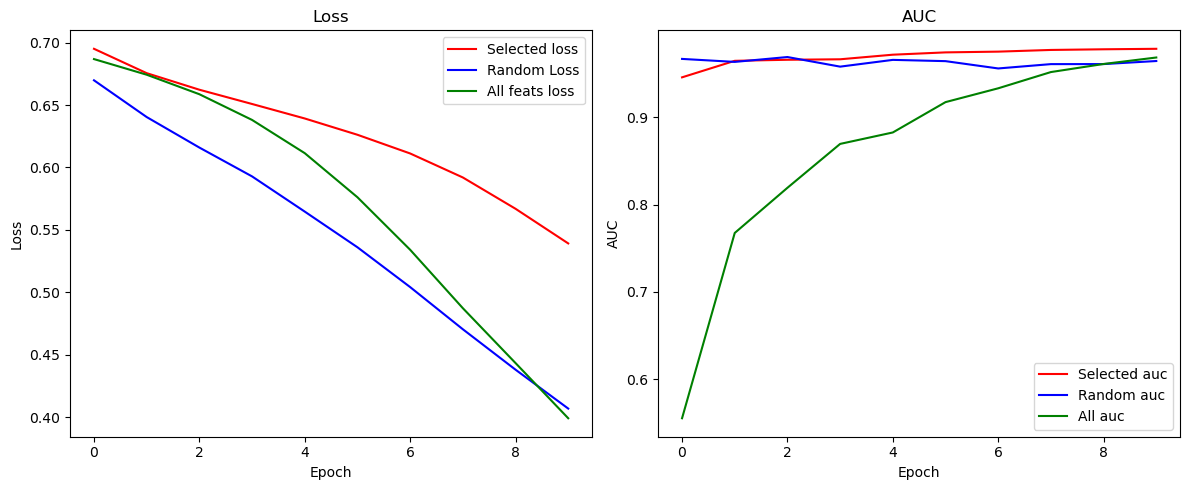

In [14]:
plot_history(history1, history2, history3)

# Use Genetic Algorithm and Simulateing Annealing Together

### Hyperparameter Search for Both Algorithm

In [15]:
# Create two lists consistingof  the different values for T and cooling rate

Ts = [1, 10, 20]
cooling_rates = [0.99, 0.95, 0.90]

scores = []  # List to keep scores
best_score = 0
best_solution = None

for T in Ts:
    for cr in cooling_rates:
        
        selected_feaures, _ = simulated_annealing(X_train, y_train, X_test, y_test, max_iter=20, T=T, cooling_rate=cr)

        s_features = [feature for feature, select in zip(X_train.columns, selected_feaures) if select]
        
        X_train_selected = X_train[s_features]

        model = nnModel(X_train_selected)
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=tf.keras.metrics.AUC())

        history = model.fit(X_train_selected, y_train, epochs=5, batch_size=32, verbose=0)

        X_test_selected = X_test[s_features]
        preds = model.predict(X_test_selected, verbose=0)
        score = roc_auc_score(y_test, preds)
        
        scores.append(score)
        
        if score > best_score:
            best_score, best_solution = score, (T, cr)
            
print(f"Best Parameters: {best_solution}\tBest: {best_score}")

iter: 0 | T: 0.99
iter: 10 | T: 0.8953382542587163
iter: 0 | T: 0.95
iter: 10 | T: 0.5688000922764596
iter: 0 | T: 0.9
iter: 10 | T: 0.31381059609000017
iter: 0 | T: 9.9
iter: 10 | T: 8.953382542587162
iter: 0 | T: 9.5
iter: 10 | T: 5.688000922764598
iter: 0 | T: 9.0
iter: 10 | T: 3.1381059609000004
iter: 0 | T: 19.8
iter: 10 | T: 17.906765085174325
iter: 0 | T: 19.0
iter: 10 | T: 11.376001845529196
iter: 0 | T: 18.0
iter: 10 | T: 6.276211921800001
Best Parameters: (20, 0.95)	Best: 0.9809983896940419


In [16]:
shape = [8,16,1] # Shape must be same with the stracture of NN
pop_size = 100 # Number or chromosomes in one population
n_generations = 10 # Number of generaions
mutation_probs = [0.001, 0.003, 0.01, 0.03, 0.1] # Mutation probability
# protected = 2 # Number of protected chromosomes

# Create genetic algorithm model

for mutation_prob in mutation_probs:

    gen = GeneticAlgorithm()

    # Train genetic algorithm model
    _, loss_hist, _ = gen.train(X_train, y_train, shape, pop_size, n_generations, mutation_prob, verbose = 0)
    print(f"Mutation probability: {mutation_prob},\t Loss: {loss_hist[-1]},\t Decrease rate: {loss_hist[0]/ loss_hist[-1]}")

Mutation probability: 0.001,	 Loss: 1.43729829788208,	 Decrease rate: 25542.874797004744
Mutation probability: 0.003,	 Loss: 1.7258472442626953,	 Decrease rate: 22509.51949348007
Mutation probability: 0.01,	 Loss: 5.48705530166626,	 Decrease rate: 8249.035516145603
Mutation probability: 0.03,	 Loss: 10.97890853881836,	 Decrease rate: 9756.291284217987
Mutation probability: 0.1,	 Loss: 7.463918685913086,	 Decrease rate: 5955.139861235298


* Best mutation parameter is 0.003 based on the last loss and decrease rate.

#### Two Algorithms Together with Best Hyperparameters

In [19]:
# cooling rate = 0.95 give error because of high iteration, we used 0.99 instead
selected_feaures, _ = simulated_annealing(X_train, y_train, X_test, y_test, max_iter=100, T=20, cooling_rate=0.99)


s_features = [feature for feature, select in zip(X_train.columns, selected_feaures) if select]

selected_num = len(s_features) # Number of selected features

selected_X_train = X_train[s_features]
selected_X_test = X_test[s_features]

iter: 0 | T: 19.8
iter: 10 | T: 17.906765085174325
iter: 20 | T: 16.194557364425172
iter: 30 | T: 14.646067393087952
iter: 40 | T: 13.245640819679672
iter: 50 | T: 11.979120129323222
iter: 60 | T: 10.833701519337072
iter: 70 | T: 9.7978054600841
iter: 80 | T: 8.86095963252345
iter: 90 | T: 8.01369305903081


In [20]:
shape = [8,16,1] # Shape must be same with the stracture of NN
pop_size = 100 # Number or chromosomes in one population
n_generations = 50 # Number of generaions
mutation_prob = 0.003 # Mutation probability
# protected = 2 # Number of protected chromosomes

# Create genetic algorithm model
gen = GeneticAlgorithm()

# Train genetic algorithm model
best, loss_hist, auc_hist = gen.train(selected_X_train, y_train, shape, pop_size, n_generations, mutation_prob, verbose = 1)

Iteration 0,	 Loss_value: 37048.23828125
Iteration 5,	 Loss_value: 163.01219177246094
Iteration 10,	 Loss_value: 3.320040464401245
Iteration 15,	 Loss_value: 3.320040464401245
Iteration 20,	 Loss_value: 2.732104778289795
Iteration 25,	 Loss_value: 0.660298228263855
Iteration 30,	 Loss_value: 0.6518819332122803
Iteration 35,	 Loss_value: 0.6518819332122803
Iteration 40,	 Loss_value: 0.6518819332122803
Iteration 45,	 Loss_value: 0.6518819332122803


In [21]:
model = nnModel(selected_X_train)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = tf.keras.metrics.AUC())

In [22]:
# Test the performance of genetic algorithm
for layer, c in zip(model.layers, best):
    layer.set_weights(c) # Set tensorflow model's weigth to weight from genetic algorithm

loss, AUC = model.evaluate(selected_X_test, y_test)
print("Loss: ", loss, "AUC Score: ", AUC)

4/4 [==============================] - 0s 2ms/step - loss: 0.6703 - auc_1233: 0.5072
Loss:  0.670348584651947 AUC Score:  0.5072463750839233


Epoch 1/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6733 - auc_1233: 0.5285
Epoch 2/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6536 - auc_1233: 0.5404
Epoch 3/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6598 - auc_1233: 0.4842
Epoch 4/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6560 - auc_1233: 0.5093
Epoch 5/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6581 - auc_1233: 0.5023
Epoch 6/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6590 - auc_1233: 0.4487
Epoch 7/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6522 - auc_1233: 0.5430
Epoch 8/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6605 - auc_1233: 0.5443
Epoch 9/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6661 - auc_1233: 0.5443
Epoch 10/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6614 - auc_1233: 0.4689
Epoch 11/20
15/15 [

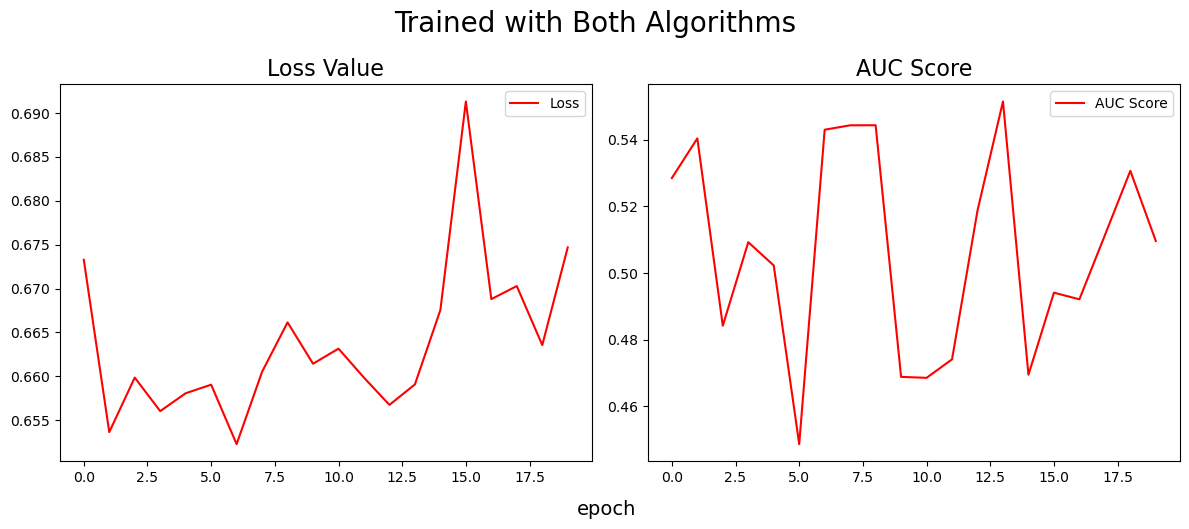

In [23]:
# Train nn model with initial weights
model_hist = model.fit(selected_X_train, y_train, epochs=20, verbose = 1)

# Evaluate performance
loss, AUC = model.evaluate(selected_X_test, y_test, verbose = 0)
print("Loss: ", loss, "AUC Score: ", AUC)

plot_hist(model_hist.history["loss"], list(model_hist.history.values())[1], title="Trained with Both Algorithms")